# Set Environment

In [83]:
# load required packages
import numpy as np
from numpy import random
from scipy.interpolate import Rbf
import umap

import copy
from collections import Counter

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline      import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.base          import BaseEstimator, TransformerMixin

from sklearn import datasets

import matplotlib.pyplot as plt

# helper function
head = lambda x, k = 6: x[:k]
tail = lambda x, k = 6: x[-k:]

# Import data

In [2]:
import sys
sys.path.append('/local_data/notebooks/clintko/GitRepo/Proj_SingleCell/Utils')

In [3]:
from Tool_ImportData import *

In [4]:
data = read_EQAPOL(fnames = [COSTIM, CMV, SEB, MARKERS])

Read Costim
Read CMV
Read SEB
Read Markers
The data Costim CMV SEB Markers are input.


In [5]:
data

{'CMV': array([array([[ 6.90890000e+04,  7.38957031e+04,  7.79019219e+04, ...,
          1.87213120e+04,  1.24512056e+04,  2.68263278e+04],
        [ 9.80290000e+04,  8.04613516e+04,  1.20354398e+05, ...,
          1.82932371e+04,  2.38339910e+04,  3.13080712e+04],
        [ 1.26360000e+04,  7.41973750e+04,  1.43060000e+04, ...,
          1.51443021e+04,  1.90007215e+04,  9.92255147e+03],
        ...,
        [ 2.61097000e+05,  0.00000000e+00, -1.03943075e+06, ...,
          5.19749905e+04, -1.85704197e+04, -1.06781493e+04],
        [ 2.61094000e+05,  6.57993047e+04,  2.62143000e+05, ...,
          4.57788193e+04, -3.80791465e+04,  8.07841217e+04],
        [ 1.21949000e+05,  1.26362961e+05,  2.35135438e+05, ...,
          4.99023097e+03,  3.04758508e+03,  4.72181335e+00]]),
        array([[ 13186.        ,  59918.17578125,  12055.68066406, ...,
          15662.610321  ,  17354.90277676,  48033.93032623],
        [ 68394.        ,  79225.40625   ,  82680.3984375 , ...,
          16990.3

# Wrapping things a class

define the class

In [160]:
class Data_Wrapper:
    """ A wrapper with data matrix (N, M_i, p) and data labels
    N   = number of samples
    M_i = number of observations / data points in the ith sample
    p   = number of variables for all sample
    Args:
        matrix (N, M_i, p): data values
        label  (N,):        labels
        coord  (Sum(M_i)):  
    """
    def __init__(self, matrix, label, coord = None):
        
        # index of each sample
        idx = [x.shape[0] for x in matrix]
        idx = np.r_[0, idx]
        idx = np.cumsum(idx)
        self.sample_idx = idx
        
        # label        
        self.label  = np.array(label)
        #assert self.label.shape[0] == matrix.shape[0], "Dimension of matrix and label does not match"
        assert len(self.label) == len(matrix), "Dimension of matrix and label does not match"
        
        # matrix
        self.matrix = np.vstack(matrix)
        
        # coordinate
        if coord:
            self.coord = np.array(coord).reshape((self.matrix.shape[0], 2))
        else:
            # initialize coordinate from “standard normal” distribution
            self.coord = random.randn(self.matrix.shape[0], 2)
        
        assert self.coord.shape[0] == self.matrix.shape[0], "Dimension of matrix and coordinate does not match"
        
    def __repr__(self):
        string = ""
        string += ("Number of samples:            " + str(self.get_num_sample())   + "\n")
        string += ("Number of variables:          " + str(self.get_num_variable()) + "\n")
        string += ("Number of total observations: " + str(self.matrix.shape[0])    + "\n")
        
        tmp = Counter(self.label)
        for k, v in tmp.items():
            string += ("Label " + str(k) + " : " + str(v) + "\n")
    
        return string
    
    def get_num_sample(self):
        return self.label.shape[0]
    
    def get_num_variable(self):
        return self.matrix.shape[1]
    
    def get_num_total_obs(self):
        return self.matrix.shape[0]
    
    def get_sample_size(self):
        return self.sample_idx[1:] - self.sample_idx[:-1]
    
    def get_sample(self, k):
        return self.matrix[self.sample_idx[k] : self.sample_idx[k + 1]] 
    
    def get_label(self, k):
        return self.label[k]
    
    def get_coord(self, k):
        return self.coord[self.sample_idx[k] : self.sample_idx[k + 1]] 
        
    def set_matrix(self, matrix):
        assert self.matrix.shape == matrix.shape
        self.matrix = matrix
    
    def set_coord(self, coord):
        # Check to make sure coord has the same number of samples
        assert self.matrix.shape[0] == coord.shape[0]
        self.coord = coord
    
    def plot_pairwise(self, ax, idx_sample, idx_feature1, idx_feature2, s = 1):
        matrix  = self.get_sample(idx_sample)
        ax.scatter(
            matrix[:, idx_feature1],
            matrix[:, idx_feature2],
            s = s)
        return ax
    
    def plot_coord(self, ax, idx_sample, idx_feature, s = 1, alpha = 0.7, cmap_color = "Reds"):
        coord   = self.get_coord(idx_sample)
        matrix  = self.get_sample(idx_sample)
        feature = matrix[:, idx_feature]
        
        ax.scatter(
            coord[:, 0], 
            coord[:, 1],
            c = feature,
            s = s,
            alpha = alpha,
            cmap=plt.get_cmap(cmap_color))
        
        return ax

In [13]:
print(data['Costim'].shape[0])
print(data['CMV'].shape[0])
print(data['SEB'].shape[0])

11
11
11


create label

In [45]:
data_label = \
    ['Costim'] * data['Costim'].shape[0] + \
    ['CMV'] * data['CMV'].shape[0] + \
    ['SEB'] * data['SEB'].shape[0]

stack all the samples

In [43]:
data_matrix = np.array(list(data['Costim']) + list(data['CMV']) + list(data['SEB']))
data_matrix.shape

(33,)

Check if the data composed together as I thought

In [37]:
head(data['Costim'][0], 2)

array([[101852.        ,  74180.6875    , 115287.0390625 ,
         17590.94539995,  54919.8280472 ,  55104.07547093,
          8990.0522919 ,  32784.75823798,  45365.09548637,
         28764.66786316,  25802.20143132,  17425.27342682,
         24886.05874349,  42322.0149073 ],
       [ 47466.        , 113790.484375  ,  82415.4453125 ,
         37795.31456801,  46940.8514795 ,   4298.60516011,
         30730.39705649,  60544.93787331,   4071.98616203,
          8641.59529032,  20409.92783463,  32883.13297334,
         34505.51827656,  52115.24941057]])

In [38]:
head(data_matrix[0], 2)

array([[101852.        ,  74180.6875    , 115287.0390625 ,
         17590.94539995,  54919.8280472 ,  55104.07547093,
          8990.0522919 ,  32784.75823798,  45365.09548637,
         28764.66786316,  25802.20143132,  17425.27342682,
         24886.05874349,  42322.0149073 ],
       [ 47466.        , 113790.484375  ,  82415.4453125 ,
         37795.31456801,  46940.8514795 ,   4298.60516011,
         30730.39705649,  60544.93787331,   4071.98616203,
          8641.59529032,  20409.92783463,  32883.13297334,
         34505.51827656,  52115.24941057]])

In [42]:
tail(data['SEB'][-1], 2)

array([[101538.        ,  75312.6640625 , 116685.4453125 ,
         13217.06311826,  56366.78859863,  56036.19093495,
         28135.61707042,   2377.82690156,  49719.87723421,
         31009.03396951,  25630.02458301,  21592.42963124,
         23775.69667072,  32131.70242305],
       [201808.        ,  85129.4453125 , 262143.        ,
         22950.79532755,  58474.58167065,  54719.17680325,
         59209.92770717,  56441.900996  ,  56146.21163673,
         31064.35414684,  35051.99429709,  27781.03523182,
         38173.00807599,  56459.75200336]])

In [41]:
tail(data_matrix[-1], 2)

array([[101538.        ,  75312.6640625 , 116685.4453125 ,
         13217.06311826,  56366.78859863,  56036.19093495,
         28135.61707042,   2377.82690156,  49719.87723421,
         31009.03396951,  25630.02458301,  21592.42963124,
         23775.69667072,  32131.70242305],
       [201808.        ,  85129.4453125 , 262143.        ,
         22950.79532755,  58474.58167065,  54719.17680325,
         59209.92770717,  56441.900996  ,  56146.21163673,
         31064.35414684,  35051.99429709,  27781.03523182,
         38173.00807599,  56459.75200336]])

wrap things up in a class

In [161]:
data_wrapped = Data_Wrapper(data_matrix, data_label)

# Subsample

In [165]:
class Transform_subsampling(BaseEstimator, TransformerMixin):
    def __init__(self, num_subsample = None, num_subsample_size = None, random_state = 0):
        self.indices = None
        self.num_subsample = num_subsample
        self.num_subsample_size = num_subsample_size
        
    def fit(self, dat, y = None):
        num_sample_sizes = dat.get_sample_size()     # array contain nrows of each sample
        num_subsample = self.num_subsample           # number of subsample created
        num_subsample_size = self.num_subsample_size # the size of each subsample
        
        self.indices = np.vstack([
            
            # generate indices of a subsample
            random.randint(
                low = 0,
                high = num_sample_size, 
                size = num_subsample_size)
            for num_sample_size in num_sample_sizes  # outter for loop: foreach sample
            for _ in range(num_subsample)])          # inner  for loop: create subsamples
        
        return self

    def transform(self, dat):
        # initialization
        lst_label  = []
        lst_matrix = []
        lst_coord  = []

        for idx_sample in range(dat.get_num_sample()):
            label  = dat.get_label(idx_sample)
            sample = dat.get_sample(idx_sample)
            coord  = dat.get_coord(idx_sample)
        
            for idx_subsample in range(self.num_subsample):
                # get
                idx = idx_sample + idx_subsample
                mat1 = sample[self.indices[idx]]
                mat2 = coord[self.indices[idx]]
            
                # store
                lst_label.append(label)
                lst_matrix.append(mat1)
                lst_coord.append(mat2)
        dat_new = Data_Wrapper(lst_matrix, lst_label, lst_coord)
        return dat_new

In [209]:
pipe = Pipeline([
    ("Scaler", Transform_subsampling(num_subsample = 1, num_subsample_size = 5000))
]) # end Pipeline

In [210]:
data_wrapped_sub = pipe.fit_transform(data_wrapped)

In [211]:
data_wrapped_sub.get_num_total_obs()

165000

# Scaling

In [218]:
class Transform_MinMaxScaler(BaseEstimator, TransformerMixin):
    def __init__(self, k = 0):
        self.x_min = 0
        self.x_max = 1
        self.k     = k
        
    def fit(self, dat, y = None):
        x_selected = dat.get_sample(self.k)
        self.x_min = np.apply_along_axis(np.min, 0, x_selected)
        self.x_max = np.apply_along_axis(np.max, 0, x_selected)
        return self

    def transform(self, dat):
        dat_copy = copy.deepcopy(dat)
        dat_copy.set_matrix((dat.matrix - self.x_min) / (self.x_max - self.x_min))
        return dat_copy

# Dimensional Reduction

In [53]:
pca = PCA(n_components = 2)
coord = pca.fit_transform(data_wrapped.matrix)

In [60]:
data_wrapped.set_coord(coord)

In [212]:
ump = umap.UMAP(random_state = 0)
coord_sub = ump.fit_transform(data_wrapped_sub.matrix)

In [213]:
data_wrapped_sub.set_coord(coord_sub)

```
##### How to use UMAP
#embedding = umap.UMAP(n_neighbors=50,
#                      alpha=0.5,
#                      init="random",
#                      min_dist=0.001)\
#                .fit_transform(iris.data)
```

# Plotting

In [64]:
data['Markers']

{'CD107 PE Cy5': 13,
 'CD14 CD19 vAmine': 3,
 'CD27 APC': 8,
 'CD3 AmCyan': 4,
 'CD4 PerCP Cy55': 5,
 'CD45RO ECD': 7,
 'CD57 FITC': 9,
 'CD8 APC Cy7': 6,
 'FSC-A': 2,
 'FSC-H': 0,
 'FSC-W': 1,
 'IFNg PE Cy7': 12,
 'IL 2 PE': 11,
 'TNFa A700': 10}

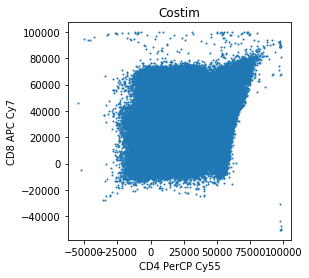

In [214]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

idx_sample = 0
data_wrapped.plot_pairwise(
    ax, 
    idx_sample = idx_sample, 
    idx_feature1 = 5, idx_feature2 = 6)

ax.set_title(data_wrapped.get_label(k = idx_sample))
ax.set_xlabel("CD4 PerCP Cy55")
ax.set_ylabel("CD8 APC Cy7")

plt.show()

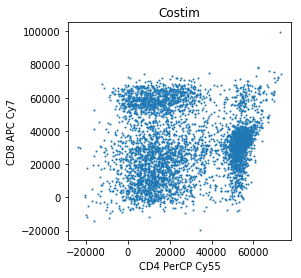

In [215]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

idx_sample = 0
data_wrapped_sub.plot_pairwise(
    ax, 
    idx_sample = idx_sample, 
    idx_feature1 = 5, idx_feature2 = 6)

ax.set_title(data_wrapped_sub.get_label(k = idx_sample))
ax.set_xlabel("CD4 PerCP Cy55")
ax.set_ylabel("CD8 APC Cy7")

plt.show()

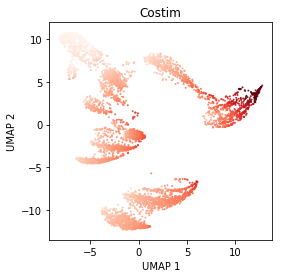

In [216]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

idx_sample = 0
idx_feature = 0

tmp = data_wrapped_sub.get_coord(k = idx_sample)
feature = data_wrapped_sub.get_sample(k = idx_sample)[:, idx_feature]

ax.scatter(
    tmp[:, 0], tmp[:, 1], 
    c = feature,
    s = 1, alpha = 0.8,
    cmap = plt.get_cmap("Reds"))

ax.set_title(data_wrapped_sub.get_label(k = idx_sample))
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")

plt.show()

In [217]:
# initialization
N_GRID  = 128

idx_sample = 0
mydata = data_wrapped_sub

# Coordinate from dimensional reduction
coord  = mydata.get_coord(idx_sample)
x = coord[:, 0]
y = coord[:, 1]
    
# generate a grid
x_c = np.linspace(min(x), max(x), N_GRID)
y_c = np.linspace(min(y), max(y), N_GRID)
x_c, y_c = np.meshgrid(x_c, y_c)
    
# Sample data
matrix = mydata.get_sample(idx_sample)
    
# images generated from interpolation 
img = []
for idx_feature in range(matrix.shape[1]):
    # interpolation
    z = matrix[:, idx_feature]
    rbfi = Rbf(x, y, z, function = 'multiquadric', smooth = 1)
        
    # store into a list "img"
    z_c = rbfi(x_c, y_c)
    img.append(z_c)
img = np.array(img)

print(img.shape)

(14, 128, 128)


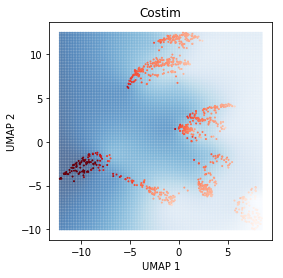

In [208]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

# initialization
idx_sample = 0
idx_feature = 2

# Coordinate from dimensional reduction
coord  = mydata.get_coord(idx_sample)
x = coord[:, 0]
y = coord[:, 1]
    
# generate a grid
x_c = np.linspace(min(x), max(x), N_GRID)
y_c = np.linspace(min(y), max(y), N_GRID)
x_c, y_c = np.meshgrid(x_c, y_c)

ax.scatter(
    x_c, y_c, c = img[idx_feature],
    s = 1, alpha = 0.5,
    cmap = plt.get_cmap("Blues"))

##########################################################################
tmp = data_wrapped_sub.get_coord(k = idx_sample)
feature = data_wrapped_sub.get_sample(k = idx_sample)[:, idx_feature]

ax.scatter(
    tmp[:, 0], tmp[:, 1], 
    c = feature,
    s = 1, alpha = 1.0,
    cmap = plt.get_cmap("Reds"))


ax.set_title(data_wrapped_sub.get_label(k = idx_sample))
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")


plt.show()

```
# initialization
N_GRID  = 128
lst_img = []

for idx_sample in range(mydata.get_num_sample()):
    
    #label  = mydata.get_label(idx_sample)
    
    # Coordinate from dimensional reduction
    coord  = mydata.get_coord(idx_sample)
    x = coord[:, 0]
    y = coord[:, 1]
    
    # generate a grid
    x_c = np.linspace(min(x), max(x), N_GRID)
    y_c = np.linspace(min(y), max(y), N_GRID)
    x_c, y_c = np.meshgrid(x_c, y_c)
    
    # Sample data
    matrix = mydata.get_sample(idx_sample)
    
    # images generated from interpolation 
    img = []
    for idx_feature in range(matrix.shape[1]):
        
        # interpolation
        z = matrix[:, idx_feature]
        rbfi = Rbf(x, y, z, function = 'multiquadric', smooth = 1)
        
        # store into a list "img"
        z_c = rbfi(x_c, y_c)
        img.append(z_c)
        
    img = np.array(img)    
    lst_img.append(img)
    
lst_img = np.array(lst_img)
lst_img_new = lst_img.reshape(-1, 128, 128)
```